# Neural Networks: MLP & CNN

## Environment Setup

**Colab (recommended, but start early since cpu/gpu resources provided reset every 24hrs)**
```bash
pip install --upgrade pip
pip install numpy pandas matplotlib scikit-learn tqdm
pip install torch torchvision
```

**Conda (need to install conda first)**
```bash
conda create -n MIE370 python=3.12 -y
conda activate MIE370
pip install --upgrade pip
pip install numpy pandas matplotlib scikit-learn tqdm jupyterlab
# PyTorch
pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128
```

**Pip (venv)**
```bash
python -m venv MIE370
source MIE370/bin/activate  # Windows: MIE370\Scripts\activate
pip install --upgrade pip
pip install numpy pandas matplotlib scikit-learn tqdm jupyterlab
pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
```

In [ ]:
!pip install --upgrade pip
!pip install numpy pandas matplotlib scikit-learn tqdm
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
%%shell
jupyter nbconvert --to html F25_MIE370_Project_4.ipynb

In [ ]:
# Environment check (optional)
import sys, platform
import numpy as np, sklearn, torch, torchvision, PIL, tqdm
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("NumPy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Torchvision:", torchvision.__version__)
print("Pillow:", PIL.__version__)

Python: 3.12.12
OS: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 2.0.2
scikit-learn: 1.6.1
PyTorch: 2.9.0+cu126 | CUDA available: False
Torchvision: 0.24.0+cu126
Pillow: 11.3.0


In [ ]:
# Reproducibility
import os, random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Robust EuroSAT loader with CA-bundle + manual-download fallback (with MD5 check).
import os, ssl, hashlib, zipfile, io
from pathlib import Path
import urllib.request
import torchvision
from torchvision import transforms

CUSTOM_CA_PEM = os.environ.get("SSL_CERT_FILE", "")
ALLOW_INSECURE_DOWNLOAD = False
EUROSAT_URL = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"
EUROSAT_MD5 = "c8fa014336c82ac7804f0398fcb19387"

def _enable_ca_bundle(ca_pem):
    if not ca_pem or not Path(ca_pem).exists():
        return False
    os.environ["SSL_CERT_FILE"] = ca_pem
    os.environ["REQUESTS_CA_BUNDLE"] = ca_pem
    try:
        ssl._create_default_https_context = lambda: ssl.create_default_context(cafile=ca_pem)
        print("[EuroSAT] Using CA bundle:", ca_pem)
        return True
    except Exception as e:
        print("[EuroSAT] Could not apply CA bundle:", e)
        return False

def _md5_bytes(b):
    m = hashlib.md5(); m.update(b); return m.hexdigest()

def _manual_download_zip(url, ca_pem=None, allow_insecure=False):
    ctx = None
    if ca_pem and Path(ca_pem).exists():
        ctx = ssl.create_default_context(cafile=ca_pem)
    elif allow_insecure:
        print("[EuroSAT] WARNING: insecure download (TLS verification disabled).")
        ctx = ssl._create_unverified_context()
    with urllib.request.urlopen(url, context=ctx) as r:
        data = r.read()
    md5 = _md5_bytes(data)
    if md5 != EUROSAT_MD5:
        raise RuntimeError(f"EuroSAT.zip MD5 mismatch: got {md5}, expected {EUROSAT_MD5}")
    return data

def load_eurosat_with_fallback(root, transform_train, transform_eval):
    root = Path(root)
    try:
        if CUSTOM_CA_PEM:
            _enable_ca_bundle(CUSTOM_CA_PEM)
        ds = torchvision.datasets.EuroSAT(root=str(root), download=True, transform=transform_train)
        return ds, ds.classes
    except Exception as e:
        print("[EuroSAT] torchvision download failed:", repr(e))
        local_dir = root / "eurosat" / "2750"
        if local_dir.is_dir():
            print("[EuroSAT] Found local directory:", local_dir, "— using ImageFolder.")
            ds = torchvision.datasets.ImageFolder(str(local_dir), transform=transform_train)
            return ds, ds.classes
        if ALLOW_INSECURE_DOWNLOAD or (CUSTOM_CA_PEM and Path(CUSTOM_CA_PEM).exists()):
            print("[EuroSAT] Attempting manual download with MD5 verification...")
            data = _manual_download_zip(EUROSAT_URL, ca_pem=CUSTOM_CA_PEM, allow_insecure=ALLOW_INSECURE_DOWNLOAD)
            base = root / "eurosat"; base.mkdir(parents=True, exist_ok=True)
            with zipfile.ZipFile(io.BytesIO(data)) as zf:
                zf.extractall(base)
            local_dir = base / "2750"
            if local_dir.is_dir():
                print("[EuroSAT] Manual download ok. Using ImageFolder.")
                ds = torchvision.datasets.ImageFolder(str(local_dir), transform=transform_train)
                return ds, ds.classes
        raise RuntimeError("EuroSAT unavailable. Provide CA bundle, enable ALLOW_INSECURE_DOWNLOAD=True, or place './data/eurosat/2750'.")

<font color="orange"><b>Please read the instructions carefully, look for all “TODO” phrases within the code, and write your answers to these parts only in the designated sections.a</b></font>


# Part A – From-scratch MLP on tabular data (NumPy)

In Part A you will implement and train a **multilayer perceptron (MLP)** from scratch using only NumPy on a small tabular **classification** dataset (phishing website detection). You will do everything manually: data preprocessing, forward pass, loss computation, backpropagation, optimization, and basic hyperparameter tuning.

Conceptually, Part A is about understanding **how neural networks work under the hood**: you will re-implement what frameworks like PyTorch or TensorFlow normally do for you.


### A1 – Data preparation & train/validation/test split

In this step you will:
- Load the **Phishing Websites** dataset from OpenML (data_id = 4534).
- Split the data into **train / validation / test** sets (60% / 20% / 20%) using **stratified** splits so that class balance is preserved.
- **Standardize features** (e.g., zero mean, unit variance) using only the training set statistics, then apply the same transform to val/test.
- Convert the labels into both:
  - **One-hot encoded** matrices (for the MLP’s softmax training),
  - And integer class labels (for later evaluation and plots).


In [ ]:
# (A1) Data prep & split — [5 pts]

# REQUIREMENTS:

# - Load OpenML Phishing Websites (data_id=4534).
# - Encode string labels into integers 0/1
# - Split into train/val/test (60/20/20) with stratification.
# - For features (x) make sure you standardize them.
# - For labels (y) apply one hot encoding.
# - Expose variables: X_train_std, X_val_std, X_test_std, Y_train_oh, Y_val_oh, Y_test_oh, y_train, y_val, y_test (Make sure they are named as indicated).


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import numpy as np


# TODO: implement the steps above
## ADD YOUR CODE HERE ##

## LOAD PHISING DATA ##
import sklearn.datasets._openml as skl_openml
import pandas as pd

skl_openml.OPENML_BASE_URL = "https://www.openml.org/api/v1/json"

data = fetch_openml(data_id=4534)

x = data.data

y = data.target

## ENCODE STRING LABELS ##
LE = LabelEncoder()
y = LE.fit_transform(y)

## SPLIT SETS ##

x_train, x2, y_train, y2 = train_test_split(x, y, train_size=0.6, test_size=0.4)

x_valid, x_test, y_val, y_test = train_test_split(x2, y2, train_size=0.5, test_size=0.5)

#x_train, x_valid, x_test, y_train, y_valid, y_test

## STANDARDIZE ##
scaler = StandardScaler()
scaler.fit(x_train)
X_train_std = scaler.fit_transform(x_train)
X_val_std = scaler.fit_transform(x_valid)
X_test_std = scaler.fit_transform(x_test)

## ONE-HOT ENCODER ##
OH = OneHotEncoder(sparse_output=False)
OH.fit(y_train.reshape(-1,1))
Y_train_oh = OH.fit_transform(y_train.reshape(-1,1))
Y_val_oh = OH.fit_transform(y_val.reshape(-1,1))
Y_test_oh = OH.fit_transform(y_train.reshape(-1,1))

## EXPOSE VARIABLES ##
X_train_std.shape, X_val_std.shape, X_test_std.shape, Y_train_oh.shape, Y_val_oh.shape, Y_test_oh.shape, y_train.shape, y_val.shape, y_test.shape

#raise NotImplementedError("A1: implement data loading, split, standardization, one-hot encoding [5 pts]")
# You are recommended to print out the shapes of the resulting arrays and some examples to get a sense of the data. This is not required but may help you debug later parts.

((6633, 30),
 (2211, 30),
 (2211, 30),
 (6633, 2),
 (2211, 2),
 (6633, 2),
 (6633,),
 (2211,),
 (2211,))

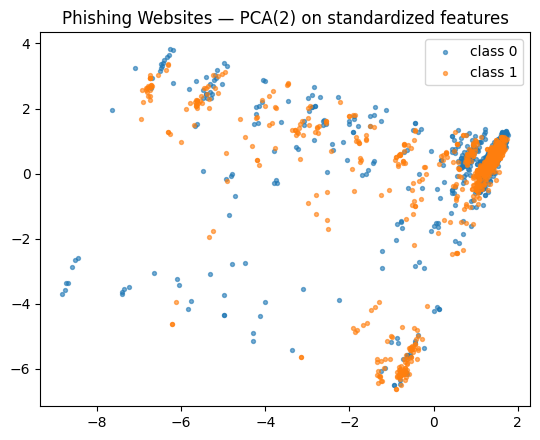

In [ ]:
# (A1) Here we provide a set of light assertions to help you verify your data loading and a quick PCA(2) scatter for you to visualize the standardized features.

import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA

assert X_train_std.ndim == 2 and X_val_std.ndim == 2 and X_test_std.ndim == 2, "Standardized feature arrays must be 2D"
assert Y_train_oh.shape[1] == 2 and Y_val_oh.shape[1] == 2 and Y_test_oh.shape[1] == 2, "One-hot should have 2 columns"
assert np.allclose(Y_train_oh.sum(axis=1), 1), "One-hot rows must sum to 1"

n_show = min(1500, X_train_std.shape[0])
idx = np.random.choice(X_train_std.shape[0], size=n_show, replace=False)
X_show = X_train_std[idx]; y_show = y_train[idx]
Z = PCA(n_components=2, random_state=0).fit_transform(X_show)

plt.figure(figsize=(5.5,4.5))
plt.scatter(Z[y_show==0,0], Z[y_show==0,1], s=8, alpha=0.6, label="class 0")
plt.scatter(Z[y_show==1,0], Z[y_show==1,1], s=8, alpha=0.6, label="class 1")
plt.title("Phishing Websites — PCA(2) on standardized features")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
# Helper utilities

import numpy as np

def softmax_logits(logits: np.ndarray, axis=1):
    z = logits - logits.max(axis=axis, keepdims=True)
    exp = np.exp(z)
    return exp / exp.sum(axis=axis, keepdims=True)

def cross_entropy(probs: np.ndarray, Y_onehot: np.ndarray, eps=1e-12):
    p = np.clip(probs, eps, 1 - eps)
    ce = -np.sum(Y_onehot * np.log(p), axis=1)
    return ce.mean()

def iterate_minibatches(X, Y, batch_size=128, shuffle=True):
    n = X.shape[0]; idx = np.arange(n)
    if shuffle: np.random.shuffle(idx)
    for i in range(0, n, batch_size):
        j = idx[i:i+batch_size]
        yield X[j], Y[j]

### A2 – Forward pass and backpropagation for the MLP (NumPy)

In this step you will implement the core computation of `MLP_Numpy`:

- **Forward pass**
  - Compute the linear + ReLU activations for the two hidden layers.
  - Compute the final logits and convert them to softmax probabilities.

- **Backward pass**
  - Compute the softmax cross-entropy loss given probabilities and one-hot labels.
  - Backpropagate gradients through the output layer and ReLU hidden layers to obtain
    gradients for all weights and biases.
  - Include L2 weight decay in both the loss and the gradients.

The `forward` method should return both the softmax probabilities and a **cache**.  
The cache is a small collection of intermediate values (for example, pre-activations
and activations) that are produced during the forward pass and reused during
backpropagation. Storing them in a cache avoids recomputing these quantities and
keeps the interface between `forward` and `loss_and_grads` clear.


In [ ]:
class MLP_Numpy:
    """3-layer MLP: D -> H1 -> H2 -> C, ReLU hidden, softmax-CE output.
    Implement forward() and loss_and_grads() WITHOUT autograd."""
    def __init__(self, D_in, H1, H2, C,
                 weight_scale=None, seed=42,
                 l2=1e-4, momentum=0.9, lr=1e-2):
        rng = np.random.default_rng(seed)

        def he(fan_in, fan_out):
            std = np.sqrt(2.0 / fan_in) if weight_scale is None else weight_scale
            return rng.normal(0.0, std, size=(fan_in, fan_out))

        self.W1 = he(D_in, H1); self.b1 = np.zeros(H1)
        self.W2 = he(H1,  H2); self.b2 = np.zeros(H2)
        self.W3 = he(H2,  C ); self.b3 = np.zeros(C)

        self.v = {
            name: np.zeros_like(param)
            for name, param in dict(
                W1=self.W1, b1=self.b1,
                W2=self.W2, b2=self.b2,
                W3=self.W3, b3=self.b3
            ).items()
        }
        self.l2 = l2
        self.momentum = momentum
        self.lr = lr

    @staticmethod
    def relu(x):
        return np.maximum(0.0, x)

    @staticmethod
    def relu_grad(x):
        """Derivative of ReLU with respect to its input."""
        grad = np.zeros_like(x)
        grad[x > 0] = 1.0
        return grad

    def forward(self, X):
        """A2: forward pass for the MLP.

        Inputs
        -------
        X : array of shape [N, D]

        Returns
        -------
        P     : array of shape [N, C] with softmax probabilities
        cache : intermediate values needed for backprop in loss_and_grads
        """


        # TODO (A2): compute Z1, A1, Z2, A2, Z3 and softmax probabilities P;
        #           store intermediates in a cache and return (P, cache).
        ## ADD YOUR CODE HERE ##

        # SET 1 #
        Z1 = np.dot(X, self.W1) + self.b1
        A1 = self.relu(Z1)

        # SET 2 #
        Z2 = np.dot(A1, self.W2) + self.b2
        A2 = self.relu(Z2)

        # SET 3 #
        Z3 = np.dot(A2, self.W3) + self.b3

        # SOFTMAX PROBABILITIES #
        P = softmax_logits(Z3)

        cache = {
            "Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2,
            "Z3": Z3,
        }

        return P, cache

        #raise NotImplementedError("A2: implement forward pass")

    def loss_and_grads(self, X, Y_onehot):
        """A2: compute softmax cross-entropy loss and gradients for all parameters.

        Inputs
        -------
        X        : [N, D], input batch
        Y_onehot : [N, C], one-hot labels

        Returns
        -------
        loss  : scalar (data loss + L2 penalty)
        grads : dict mapping parameter name -> gradient array
        """


        # TODO (A2): call forward(...) to get P and cache, compute cross-entropy
        #           loss with L2 penalty, then backpropagate using relu_grad(...)
        #           and the cached intermediates to fill grads.
        ## ADD YOUR CODE HERE ##
        P, cache = self.forward(X)
        N = X.shape[0]

        # LOSS #
        ce = cross_entropy(P, Y_onehot)
        L2 = 0.5 * self.l2 * (np.sum(self.W1**2) + np.sum(self.W2**2) + np.sum(self.W3**2))

        loss = ce + L2

        # GRADIENTS #
        dZ3 = (P - Y_onehot)/N

        dW3 = np.dot(cache["A2"].T, dZ3) + self.l2 * self.W3
        db3 = np.sum(dZ3, axis=0)

        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu_grad(cache["Z2"])

        dW2 = np.dot(cache["A1"].T, dZ2) + self.l2 * self.W2
        db2 = np.sum(dZ2, axis=0)

        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu_grad(cache["Z1"])

        dW1 = np.dot(X.T, dZ1) + self.l2 * self.W1
        db1 = np.sum(dZ1, axis=0)

        grads = {
            "W1": dW1,
            "b1": db1,
            "W2": dW2,
            "b2": db2,
            "W3": dW3,
            "b3": db3
            }

        return loss, grads
        #raise NotImplementedError("A2: implement loss_and_grads")

    def step(self, grads):
        """Momentum SGD update of all parameters in-place."""
        for name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
            self.v[name] = self.momentum * self.v[name] - self.lr * grads[name]
            setattr(self, name, getattr(self, name) + self.v[name])


In [ ]:
# (A2) Forward/backward shape checks (run AFTER implementing MLP methods)

import numpy as np

D = 10; H1 = 6; H2 = 4; C = 2; n = 5
model = MLP_Numpy(D, H1, H2, C)
X = np.random.randn(n, D)
Y = np.eye(C)[np.random.randint(0, C, size=n)]

try:
    P, cache = model.forward(X)
    assert P.shape == (n, C), f"softmax probs must be (n, C), got {P.shape}"
    loss, grads = model.loss_and_grads(X, Y)
    for k in ["W1", "b1", "W2", "b2", "W3", "b3"]:
        assert grads[k].shape == getattr(model, k).shape, f"grad shape mismatch for {k}"
    print("✓ Forward/backward basic shape checks passed.")
except NotImplementedError:
    print("Implement MLP methods first to run this check.")


✓ Forward/backward basic shape checks passed.


### A3 – Numerical gradient checking

In this step you will:
- Implement a **finite-difference gradient check** for the MLP:
  - For a **tiny batch** of inputs and labels, slightly perturb each parameter.
  - Approximate the gradient numerically and compare it to your manual gradients from `loss_and_grads`.
- Report whether the gradients match within reasonable tolerances and, if not, print useful debugging info.


In [ ]:
# (A3) Numerical gradient check — [7 pts]

def numerical_grad_check(model, X_small, Y_small, eps=1e-5, atol=1e-4, rtol=1e-2):
  """Finite-difference gradient check for MLP_Numpy.

  For each parameter tensor in the model, this function compares the
  analytical gradient from `loss_and_grads` with a numerical gradient
  computed via centered finite differences.

  Returns
  -------
  ok : bool
      True if all gradients pass the tolerance checks; False otherwise.
  """


  # TODO: implement finite-difference checking; print mismatches; return True/False
  ## ADD YOUR CODE HERE ##

  ok = True
  #get loss and gradients
  loss, grads = model.loss_and_grads(X_small, Y_small)

  #examine each parameter
  for name in ["W1", "b1", "W2", "b2", "W3", "b3"]:
    param = getattr(model, name)
    grad_analytic = grads[name]
    grad_numeric = np.zeros_like(param)

    for k in np.ndindex(param.shape):
      iv = param[k]

      #plus
      param[k] = iv + eps
      lossplus, _ = model.loss_and_grads(X_small, Y_small)

      #minus
      param[k] = iv - eps
      lossminus, _ = model.loss_and_grads(X_small, Y_small)

      #norm
      param[k] = iv

      #calc numeric val
      grad_numeric[k] = (lossplus - lossminus) / (2 * eps)

    #Calculate difference
    # compare analytic vs numeric
    diff = np.abs(grad_analytic - grad_numeric)
    tol = atol + rtol * np.abs(grad_analytic)

    if np.any(diff > tol):
        ok = False

  return ok

  #raise NotImplementedError("A3: implement numerical gradient check [7 pts]")


In [ ]:
# (A3) Sanity check: use numerical_grad_check to verify forward/backward
# Small synthetic batch (does NOT depend on A1 data)

D, H1, H2, C, n = 10, 6, 4, 2, 5
np.random.seed(0)

model = MLP_Numpy(D, H1, H2, C)

# Random inputs and one-hot labels
X_small = np.random.randn(n, D)
y_small_int = np.random.randint(0, C, size=n)
Y_small = np.eye(C)[y_small_int]

try:
    # ---- Forward sanity checks ----
    P, _ = model.forward(X_small)
    assert P.shape == (n, C), f"Expected probs shape {(n, C)}, got {P.shape}"
    row_sums = P.sum(axis=1)
    assert np.allclose(row_sums, 1.0, atol=1e-5), \
        f"Softmax rows must sum to 1 (got {row_sums})"
    print("✓ Forward pass shape + softmax checks passed.")

    # ---- Numerical gradient check (A3) ----
    ok = numerical_grad_check(model, X_small, Y_small)
    if ok:
        print("✓ Numerical gradient check PASSED for this random batch.")
    else:
        print("✗ Numerical gradient check FAILED — see mismatch printed above.")
except NotImplementedError as e:
    print("NotImplementedError raised:", e)
    print("Make sure you have implemented:")
    print("  - MLP_Numpy.forward (A2)")
    print("  - MLP_Numpy.loss_and_grads (A2)")
    print("  - numerical_grad_check (A3)")


✓ Forward pass shape + softmax checks passed.
✓ Numerical gradient check PASSED for this random batch.


### A4 – Training loop with SGD + momentum and early stopping

In this step you will:
- Implement a **mini-batch training loop** for the MLP using **SGD with momentum**:
  - Iterate over shuffled mini-batches.
  - Call your `loss_and_grads` function, then update parameters using the stored velocity terms.
- Implement **early stopping** based on validation loss:
  - Track train/val loss over epochs.
  - Stop training when validation loss no longer improves after a patience window.
- Implement a simple **prediction helper** that converts model outputs into integer class predictions.


In [ ]:
# (A4) Training loop (SGD+momentum, early stopping) — [8 pts]

def train_mlp(model, Xtr, Ytr, Xva, Yva, epochs=80, batch=128, patience=8):
    """Train MLP_Numpy with mini-batch SGD + momentum and early stopping.

    Parameters
    ----------
    model : MLP_Numpy
    Xtr, Ytr : training data and one-hot labels
    Xva, Yva : validation data and one-hot labels
    epochs : int
        Maximum number of passes over the training set.
    batch : int
        Mini-batch size.
    patience : int
        Number of epochs without improvement on validation loss before stopping.

    Returns
    -------
    hist : dict
        Dictionary with keys "train_loss", "val_loss", "train_acc", "val_acc".
    """


    # TODO: implement training loop with momentum and early stopping; return history dict
    ## ADD YOUR CODE HERE ##
    hist = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_val_loss = float("inf")
    patience_counter = 0
    for epoch in range(epochs):
      # Train on all batches for this epoch
      for X_batch, Y_batch in iterate_minibatches(Xtr, Ytr, batch):
          loss, grads = model.loss_and_grads(X_batch, Y_batch)
          model.step(grads)

      # Evaluate once per epoch (AFTER all batches)
      tl, _ = model.loss_and_grads(Xtr, Ytr)
      vl, _ = model.loss_and_grads(Xva, Yva)

      hist["train_loss"].append(tl)
      hist["val_loss"].append(vl)

      # Compute accuracy
      tp = predict_classes(model, Xtr)
      vp = predict_classes(model, Xva)

      # Convert one-hot to class labels for comparison
      y_train_labels = np.argmax(Ytr, axis=1)
      y_val_labels = np.argmax(Yva, axis=1)

      hist["train_acc"].append(np.mean(tp == y_train_labels))
      hist["val_acc"].append(np.mean(vp == y_val_labels))

      # Early stopping check
      if vl < best_val_loss:
          best_val_loss = vl
          patience_counter = 0
      else:
          patience_counter += 1
          if patience_counter >= patience:
              print(f"Early stopping at epoch {epoch+1}")
              break

    return hist

    #raise NotImplementedError("A5: implement training loop [8 pts]")

def predict_classes(model, X):
    """Return integer class predictions via softmax."""


    # TODO: return integer class predictions via softmax
    ## ADD YOUR CODE HERE ##
    P, _ = model.forward(X)
    return np.argmax(P, axis=1)


    #raise NotImplementedError("A5: implement predict helper")


In [ ]:
# (A4) Sanity assertion (runs AFTER A5 is implemented) — moved after training implementation

try:
    n_small = min(256, X_train_std.shape[0])
    idx = np.random.choice(X_train_std.shape[0], size=n_small, replace=False)
    Xtr_s, Ytr_s = X_train_std[idx], Y_train_oh[idx]
    Xva_s, Yva_s = X_val_std, Y_val_oh

    model = MLP_Numpy(D_in=Xtr_s.shape[1], H1=64, H2=32, C=Ytr_s.shape[1], l2=5e-4, lr=5e-3, momentum=0.9)
    hist = train_mlp(model, Xtr_s, Ytr_s, Xva_s, Yva_s, epochs=10, batch=64, patience=3)
    assert len(hist.get("val_loss",[]))>0, "val_loss history must be recorded"
    assert min(hist["val_loss"]) <= hist["val_loss"][0], "validation loss should not strictly worsen"
    print("✓ Training sanity check: curves recorded and show some improvement.")
except NotImplementedError:
    print("Implement training loop first to run this check.")
except NameError:
    print("Finish A1 before running this check.")


✓ Training sanity check: curves recorded and show some improvement.


### A5 – Final training, curves, and evaluation (with hyperparameter tuning)

In this step you will:
- Use the **hyperparameter tuning setup** (A_HPARAMS / A_GRID) to search over a small set of MLP configurations (hidden sizes, learning rate, momentum, L2).
- Select a **best configuration based on validation performance**, then:
  - Train the MLP using that setting.
  - Plot **training vs validation loss curves** using the provided plotting utility.
  - Report **test set performance** (at least accuracy, optionally more metrics).

**Why this matters:**
Here you put everything together: data prep, model, backprop, training loop, and tuning. You also practice reading learning curves and using validation data to choose hyperparameters before reporting test results.


In [ ]:
# (A5) Plot utilities

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_curves(hist, title="MLP loss curves"):
    plt.figure(); plt.plot(hist.get("train_loss",[]), label="train"); plt.plot(hist.get("val_loss",[]), label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title(title); plt.show()


In [ ]:
# (A5) Evaluation & Reporting — [7 pts]

# TODO: Train your best MLP on (train) with tuned hyperparameters, track val loss.
# TODO: Plot learning curves with plot_curves(...).
# TODO: Evaluate on test set.
# Include your best hyperparameters in the section below (Hyperparameter Tuning).
# Present the test set classification report and confusion matrix for your best model.


## ADD YOUR CODE HERE ##
from itertools import product

def training_eval(X_train, Y_train, X_val, Y_val, epochs, batch, patience, A_HPARAMS, A_GRID):
    best_cfg, best_val, best_model, best_hist = None, float("inf"), None, None

    for H1, H2, lr, l2 in product(A_GRID["H1"], A_GRID["H2"], A_GRID["lr"], A_GRID["l2"]):
        current_cfg = {"H1": H1, "H2": H2, "lr": lr, "l2": l2}
        print(f"Trying configuration: {current_cfg}")

        model = MLP_Numpy(
            D_in=X_train.shape[1],
            H1=H1, H2=H2,
            C=Y_train.shape[1],
            l2=l2, lr=lr,
            momentum=A_HPARAMS["momentum"]
        )

        hist = train_mlp(
            model,
            X_train, Y_train,
            X_val, Y_val,
            epochs=epochs,
            batch=batch,
            patience=patience
        )

        val_loss = hist["val_loss"][-1]
        if val_loss == None:
          best_val = val_loss
          best_cfg = current_cfg
          best_model = model
          best_hist = hist
        if val_loss < best_val:
          best_val = val_loss
          best_cfg = current_cfg
          best_model = model
          best_hist = hist

    return best_cfg, best_val, best_model, best_hist

In [ ]:
# Part A — Hyperparameter Tuning starter
# Define your base hyperparameters, then expand to a small grid and report the best.
A_HPARAMS = {
    "H1": 128,
    "H2": 64,
    "lr": 5e-3,
    "l2": 5e-4,
    "momentum": 0.9,
    "batch": 128,
    "epochs": 50,
    "patience": 8,
}
print("Base A_HPARAMS:", A_HPARAMS)

# Suggested grid to explore (edit/expand as needed):
A_GRID = {
    "H1": [64, 128],
    "H2": [32, 64],
    "lr": [5e-3, 1e-2],
    "l2": [1e-4, 5e-4],
}


# TODO (HPT): loop over A_GRID, train using train_mlp(...), track best val performance, and report the chosen setting.
## ADD YOUR CODE HERE ##

#X_train_std, X_val_std, X_test_std, Y_train_oh, Y_val_oh, Y_test_oh, y_train, y_val, y_test

best_cfg, best_val, best_model, best_hist = training_eval(
    X_train_std, Y_train_oh, X_val_std, Y_val_oh,  # correct
    A_HPARAMS["epochs"], A_HPARAMS["batch"], A_HPARAMS["patience"],
    A_HPARAMS, A_GRID
)

print("Best A HParams:", best_cfg, "val_loss=", best_val)

print(best_hist)


# Hint: (Pseudocode provided below)
# best_cfg, best_val = None, float("inf")
# for each combo in product(A_GRID):
#     model = MLP_Numpy(D_in=X_train_std.shape[1], H1=..., H2=..., C=Y_train_oh.shape[1],
#                       l2=..., lr=..., momentum=A_HPARAMS["momentum"])
#     hist = train_mlp(model, X_train_std, Y_train_oh, X_val_std, Y_val_oh,
#                      epochs=A_HPARAMS["epochs"], batch=A_HPARAMS["batch"], patience=A_HPARAMS["patience"])
#     val = hist["val_loss"][-1]
#     if val < best_val: best_val, best_cfg = val, current_cfg
# print("Best A HParams:", best_cfg, "val_loss=", best_val)

Base A_HPARAMS: {'H1': 128, 'H2': 64, 'lr': 0.005, 'l2': 0.0005, 'momentum': 0.9, 'batch': 128, 'epochs': 50, 'patience': 8}
Trying configuration: {'H1': 64, 'H2': 32, 'lr': 0.005, 'l2': 0.0001}
Trying configuration: {'H1': 64, 'H2': 32, 'lr': 0.005, 'l2': 0.0005}
Trying configuration: {'H1': 64, 'H2': 32, 'lr': 0.01, 'l2': 0.0001}
Trying configuration: {'H1': 64, 'H2': 32, 'lr': 0.01, 'l2': 0.0005}
Trying configuration: {'H1': 64, 'H2': 64, 'lr': 0.005, 'l2': 0.0001}
Trying configuration: {'H1': 64, 'H2': 64, 'lr': 0.005, 'l2': 0.0005}
Trying configuration: {'H1': 64, 'H2': 64, 'lr': 0.01, 'l2': 0.0001}
Trying configuration: {'H1': 64, 'H2': 64, 'lr': 0.01, 'l2': 0.0005}
Trying configuration: {'H1': 128, 'H2': 32, 'lr': 0.005, 'l2': 0.0001}
Trying configuration: {'H1': 128, 'H2': 32, 'lr': 0.005, 'l2': 0.0005}
Trying configuration: {'H1': 128, 'H2': 32, 'lr': 0.01, 'l2': 0.0001}
Early stopping at epoch 49
Trying configuration: {'H1': 128, 'H2': 32, 'lr': 0.01, 'l2': 0.0005}
Trying con

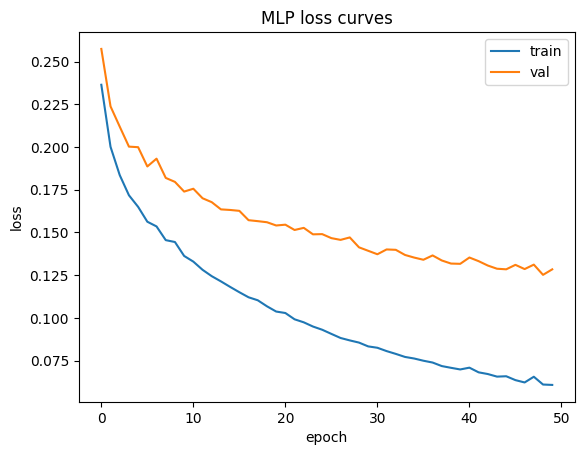

In [ ]:
# TODO Plot learning curves for your best model here
## ADD YOUR CODE HERE ##
plot_curves(best_hist)


In [ ]:
# TODO Evaluate on test set and print classification results (Test accuracy, precision, recall, f1) + confusion matrix
## ADD YOUR CODE HERE ##
y_pred = predict_classes(best_model, X_test_std)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       945
           1       0.97      0.96      0.96      1266

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211

[[ 901   44]
 [  49 1217]]


### (A6) Short Answers — **3 pts**
1. Why does feature standardization help MLP training?  
2. Where does L2 regularization enter your gradients, and what effect does it have?  
3. If you replace ReLU with tanh, what two training/optimization changes do you expect and why?

In [ ]:
'''

ADD YOUR ANSWERS HERE

Question 1:
By standardizing the features prior to training, it prevents the model from becoming overly sensitive to the scale of input. For example,
if a particular categories has a mean of 100 while another has a mean of 2, the feature with mean 100 would dominate the model.

Question 2:
L2 Regularization enters in 2 places; 1) Calculating the loss and 2) Calculating the gradient weights. This feature in the model creation
prevents the introduction of larger weight by penalizing them.

Question 3:
ReLU prevents negative outputs (sets to 0) while tanh ajusts the outputs to fit within the [-1,1] (sets extremes to 1 or -1). The first
change would be the learning rate and epochs; since tanh squeezes on both ends of the function, it is more likely that the model will
require a lower learning rate and greater number of epochs to prevent vanishing gradients.The second change expected would be differing
initialization weights given that the function is centered around 0 and starts at 1.


'''

'\n\nADD YOUR ANSWERS HERE\n\nQuestion 1:\nBy standardizing the features prior to training, it prevents the model from becoming overly sensitive to the scale of input. For example,\nif a particular categories has a mean of 100 while another has a mean of 2, the feature with mean 100 would dominate the model.\n\nQuestion 2: \nL2 Regularization enters in 2 places; 1) Calculating the loss and 2) Calculating the gradient weights. This feature in the model creation\nprevents the introduction of larger weight by penalizing them. \n\nQuestion 3:\nReLU prevents negative outputs (sets to 0) while tanh ajusts the outputs to fit within the [-1,1] (sets extremes to 1 or -1). The first \nchange would be the learning rate and epochs; since tanh squeezes on both ends of the function, it is more likely that the model will \nrequire a lower learning rate and greater number of epochs to prevent vanishing gradients.The second change expected would be differing \ninitialization weights given that the func

# Part B – CNNs on image data (PyTorch)

In Part B you will move from NumPy to **PyTorch** and from tabular data to **image classification** using the EuroSAT satellite imagery dataset. Instead of writing backprop by hand, you will focus on designing models, data pipelines, and experiments while letting PyTorch handle automatic differentiation.

Conceptually, Part B is about practicing **modern deep-learning workflows**: using high-level tools (PyTorch) to design CNN architectures, run controlled experiments, and interpret empirical results.


### B1 – Data pipeline and DataLoaders for EuroSAT

In this step you will:

- Define an evaluation transform `transform_eval` that
  - resizes images to **64×64**, and  
  - converts them to PyTorch tensors (you may also normalize them).
- Load the **EuroSAT** dataset using the provided helper and obtain
  `train_full`, `classes`, and `num_classes`.
- Split `train_full` into **train / validation / test** subsets using a fixed
  random seed for reproducibility.
- Implement `make_loaders(batch=..., train_transform=None)` to create
  `DataLoader` objects for train/val/test, where an optional `train_transform`
  is applied only to the training subset.

Data augmentation will be introduced later; here you just build a clean and
reusable input pipeline.


In [ ]:
# (B1) Data pipeline & loaders — [5 pts]

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch

data_root = "./data"


# TODO (B1): define transform_eval (Resize to 64×64 + ToTensor, optionally Normalize)
transform_eval = None  # replace with transforms.Compose([...])
## ADD YOUR CODE HERE ##

transform_eval = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),                  # convert PIL image → tensor
    transforms.Normalize((0.485, 0.456, 0.406), #RGB Normalization
                         (0.229, 0.224, 0.225))   # normalize channels (std)
])

# TODO (B1): call load_eurosat_with_fallback(...) with transform_eval
# Hint: Example (you may adapt):
# train_full, classes = load_eurosat_with_fallback(root=data_root, transform=transform_eval)
# num_classes = len(classes)
## ADD YOUR CODE HERE ##
train_full, classes = load_eurosat_with_fallback(
    root=data_root,
    transform_train=transform_eval,
    transform_eval=transform_eval
)
num_classes = len(classes)

#print(f"Loaded EuroSAT: {len(train_full)} images, {num_classes} classes")
#print(f"Classes: {classes}")


# TODO (B1): split train_full into train_ds, val_ds, test_ds with a fixed random seed
# Use torch.utils.data.random_split and make sure the sizes sum to len(train_full)
## ADD YOUR CODE HERE ##

total_size = len(train_full)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

seed = 0

train_ds, val_ds, test_ds = random_split(
    train_full,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(seed)
)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

def make_loaders(batch=128, train_transform=None):
    """Create DataLoaders for train/val/test.

    - If train_transform is not None, it should be used for the training subset only.
    - Validation and test subsets should always use transform_eval.
    """

    # TODO (B1): set the transforms on the underlying datasets and wrap them in DataLoaders.
    ## ADD YOUR CODE HERE ##
    if train_transform is not None:
      train_ds.dataset.transform = train_transform
    else:
      train_ds.dataset.transform = transform_eval

    val_ds.dataset.transform = transform_eval
    test_ds.dataset.transform = transform_eval

    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch, shuffle=False)

    return train_loader, val_loader, test_loader

    #raise NotImplementedError("B1: implement make_loaders")


100%|██████████| 94.3M/94.3M [00:00<00:00, 278MB/s]


Train/Val/Test sizes: 16200/5400/5400


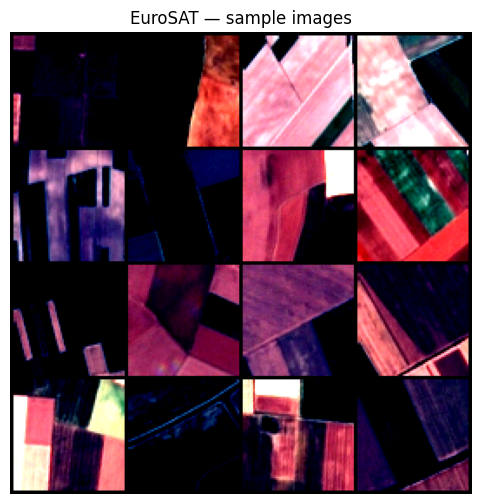

In [ ]:
# (B1) Visualization — Sample gallery (run after B1 is implemented)

import numpy as np, matplotlib.pyplot as plt, torchvision
try:
    assert 'train_full' in globals() and 'classes' in globals(), "Run B1 first to define 'train_full' and 'classes'"
    idxs = list(range(min(16, len(train_full))))
    imgs = [train_full[i][0] for i in idxs]
    ys   = [train_full[i][1] for i in idxs]
    grid = torchvision.utils.make_grid(torch.stack(imgs), nrow=4)
    npimg = grid.numpy().transpose(1,2,0)
    plt.figure(figsize=(6,6)); plt.imshow(np.clip(npimg,0,1)); plt.axis('off')
    plt.title("EuroSAT — sample images")
    plt.show()
except Exception as e:
    print("Sample gallery unavailable until B1 is implemented.", e)

In [ ]:
# (B1) Loader sanity checks (optional but recommended)

try:
    train_loader, val_loader, test_loader = make_loaders(batch=128)
    xb, yb = next(iter(train_loader))
    assert xb.ndim == 4 and xb.shape[1] == 3 and xb.shape[2] == 64 and xb.shape[3] == 64
    assert yb.ndim == 1 and yb.dtype == torch.long
    print("✓ Data loader sanity checks passed.")
except NotImplementedError:
    print("Implement B1 (make_loaders) first to run this check.")
except AssertionError as e:
    print("Sanity check failed:", e)


✓ Data loader sanity checks passed.


### B2 – CNN architectures: baseline CNN_A and improved CNN_B

In this step you will implement two convolutional networks for 64×64 RGB inputs:

1. **CNN_A – Baseline CNN**
   - Two convolutional blocks (convolution → ReLU → pooling).
   - A simple fully connected head mapping to `num_classes` logits.

2. **CNN_B – Improved CNN**
   - A more advanced design than CNN_A. Possible changes include:
     - An extra convolutional block (deeper network),
     - Wider feature maps,
     - Dropout in the classifier head,
     - Other architectural tweaks that keep the model size reasonable.
   - Remember to include non-linearities (e.g., ReLU) between convolutional
     layers and in the classifier head.

Both networks should:
- take inputs of shape **[B, 3, 64, 64]**, and  
- return logits of shape **[B, num_classes]** to be used with `F.cross_entropy`.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_A(nn.Module):
    """Baseline CNN with two conv blocks and a small MLP classifier.

    Input:  [B, 3, 64, 64]
    Output: [B, num_classes] logits
    """
    def __init__(self, num_classes):
        super().__init__()


        # TODO (B2): define layers for CNN_A
        # Example structure (you may follow this pattern or a similar one):
        #   conv -> ReLU -> max pool  -> conv -> ReLU -> max pool -> flatten -> linear(s)
        ## ADD YOUR CODE HERE ##

        #3 to 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #32 to 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        #after two pools
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

        #raise NotImplementedError("B2: define CNN_A layers")

    def forward(self, x):
        # TODO (B2): implement forward pass for CNN_A
        ## ADD YOUR CODE HERE ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

        #raise NotImplementedError("B2: implement CNN_A.forward")

class CNN_B(nn.Module):
    """Improved CNN (deeper/wider and possibly with dropout) than CNN_A."""
    def __init__(self, num_classes):
        super().__init__()
        # TODO (B2): define layers for CNN_B
        # Use convolution → non-linearity (e.g., ReLU) → pooling blocks,
        # then a classifier head that outputs num_classes logits.
        # You may include extra conv blocks, wider channels, and/or dropout.
        ## ADD YOUR CODE HERE ##

        #define conv blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        #define pools
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        #define fc
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)

        #define dropout
        self.dropout = nn.Dropout(0.5)

        #raise NotImplementedError("B2: define CNN_B layers")

    def forward(self, x):
        # TODO (B2): implement forward pass for CNN_B
        ## ADD YOUR CODE HERE ##
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

        #raise NotImplementedError("B2: implement CNN_B.forward")


In [ ]:
# (B2) Model forward shape checks

import torch
try:
    mA = CNN_A(num_classes).to(device)
    mB = CNN_B(num_classes).to(device)
    train_loader, _, _ = make_loaders(batch=8)
    xb, yb = next(iter(train_loader))
    xb = xb.to(device)
    logitsA = mA(xb); logitsB = mB(xb)
    assert logitsA.shape == (xb.size(0), num_classes), f"CNN_A logits must be [B, C], got {logitsA.shape}"
    assert logitsB.shape == (xb.size(0), num_classes), f"CNN_B logits must be [B, C], got {logitsB.shape}"
    print("✓ CNN_A/CNN_B forward shape checks passed.")
except NotImplementedError:
    print("Implement models and loaders first to run this check.")
except Exception as e:
    print("Model forward shape check failed:", e)


✓ CNN_A/CNN_B forward shape checks passed.


### B3 – Optimizers, learning-rate schedulers, training loop, and hyperparameter tuning

In this step you will:

- Implement an optimizer factory `make_optimizer` that
  - supports at least `"adam"` and `"sgd"` (with momentum), and
  - accepts learning rate and weight decay as arguments.
- Implement a scheduler factory `make_scheduler` that
  - supports at least `"cosine"` and `"step"` learning-rate schedules, and
  - returns `None` when no schedule is used.
- Implement a training helper `train_one_model(...)` that
  - trains a model on `train_loader` and evaluates on `val_loader` each epoch,
  - tracks losses and accuracies over epochs,
  - optionally applies a learning-rate scheduler, and
  - uses simple early stopping based on validation performance.

Then use these components to run a small hyperparameter study:

- Define a base configuration `B_HPARAMS` and a small grid `B_GRID` over
  - model choice (**CNN_A** vs **CNN_B**),
  - optimizer (`"adam"` vs `"sgd"`),
  - learning rate and weight decay,
  - scheduler choice (`"cosine"` vs `"step"`).
- For at least **6 configurations**, train models and compare validation performance.
- Summarize your runs in a small table (e.g., a `pandas.DataFrame`) and identify
  the best setting that you will reuse in later parts.


In [ ]:
# (B3) Optimizers, schedulers, and training loop — [10 pts]

from collections import defaultdict
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_optimizer(model, opt_name="adam", lr=1e-3, weight_decay=0.0, momentum=0.9):
    """B3: create an optimizer for model parameters.

    Supported opt_name values:
    - "adam": Adam optimizer
    - "sgd" : SGD with momentum
    """


    # TODO (B3): return an optimizer instance based on opt_name and the arguments.
    ## ADD YOUR CODE HERE ##

    if opt_name == "adam":
      return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    if opt_name == "sgd":
      return optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

    #raise NotImplementedError("B3: implement make_optimizer")

def make_scheduler(optimizer, sched_name="none", epochs=20, step_size=10, gamma=0.1):
    """B3: create a learning-rate scheduler.

    Supported sched_name values:
    - "none"  :  no scheduler (returns None)
    - "cosine": CosineAnnealingLR over the given number of epochs
    - "step"  : StepLR with provided step_size and gamma
    """
    # TODO (B3): return a scheduler instance or None if no schedule is used.
    ## ADD YOUR CODE HERE ##

    if sched_name == "none":
      return None

    if sched_name == "cosine":
      return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    if sched_name == "step":
      return optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    #raise NotImplementedError("B3: implement make_scheduler")

def train_one_model(
    model,
    train_loader,
    val_loader,
    epochs=20,
    opt_cfg=None,
    sched_name="none",
    patience=5,
):
    """B3: standard supervised training loop with optional LR scheduler
    and early stopping.

    Returns the (possibly early-stopped) model and a history dict with
    keys such as "train_loss", "val_loss", "train_acc", "val_acc".
    """
    # TODO (B3): implement the training loop using make_optimizer and make_scheduler.
    ## ADD YOUR CODE HERE ##

    #import model
    model.to(device)

    #get optimizer & scheduler
    optimizer = make_optimizer(model, **opt_cfg)
    scheduler = make_scheduler(optimizer, sched_name, epochs)

    hist = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      #Training Set
      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        pred = model(images)
        loss = F.cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_acc = correct / total

      hist['train_loss'].append(train_loss)
      hist['train_acc'].append(train_acc)

      #Validation Set
      model.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
        for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          pred = model(images)
          loss = F.cross_entropy(pred, labels)
          val_loss += loss.item()
          _, predicted = torch.max(pred.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      val_loss /= len(val_loader)
      val_acc = correct / total

      hist['val_loss'].append(val_loss)
      hist['val_acc'].append(val_acc)

      if scheduler is not None:
        scheduler.step()

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
      else:
        patience_counter += 1
        if patience_counter >= patience:
          print(f"Early stopping at epoch {epoch+1}")
          break

    return model, hist

    #raise NotImplementedError("B3: implement train_one_model")


In [ ]:
# (B3) Training loop sanity assertion
try:
    train_loader, val_loader, test_loader = make_loaders(batch=64)
    model = CNN_A(num_classes).to(device)
    model, hist = train_one_model(
        model,
        train_loader,
        val_loader,
        epochs=2,
        opt_cfg={"opt_name": "adam", "lr": 1e-3, "weight_decay": 0.0, "momentum": 0.9},
        sched_name="cosine",
        patience=1,
    )
    assert "val_loss" in hist and len(hist["val_loss"]) > 0, "val_loss must be tracked"
    print("✓ Training loop sanity check passed (short run).")
except NotImplementedError:
    print("Implement B1, B2, and B3 first to run this check.")
except Exception as e:
    print("Training loop sanity check failed:", e)


✓ Training loop sanity check passed (short run).


In [ ]:
# Part B — Hyperparameter tuning starter
# Define base settings; expand to a few variants and compare val/test acc.

B_HPARAMS = {
    "model": "CNN_A",      # or "CNN_B"
    "opt_name": "adam",
    "lr": 1e-3,
    "weight_decay": 5e-4,
    "sched_name": "cosine",
    "epochs": 12,
    "batch": 128,
    "momentum": 0.9,
}
print("Base B_HPARAMS:", B_HPARAMS)

# Suggested ranges to explore (edit as needed):
B_GRID = {
    "model": ["CNN_A", "CNN_B"],
    "opt_name": ["adam", "sgd"],
    "lr": [5e-4, 1e-3, 5e-3],
    "weight_decay": [0.0, 5e-4],
    "sched_name": ["cosine", "step"],
}

print("Example B_GRID keys:", list(B_GRID.keys()))


Base B_HPARAMS: {'model': 'CNN_A', 'opt_name': 'adam', 'lr': 0.001, 'weight_decay': 0.0005, 'sched_name': 'cosine', 'epochs': 12, 'batch': 128, 'momentum': 0.9}
Example B_GRID keys: ['model', 'opt_name', 'lr', 'weight_decay', 'sched_name']


In [ ]:
# (B3) Hyperparameter search and results table — [10 pts]

import pandas as pd, time

def evaluate_on(loader, model):
    model.eval(); correct = 0; n = 0; loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss_sum += loss.item() * xb.size(0)
            n += xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
    return {"loss": loss_sum / max(1, n), "acc": correct / max(1, n)}

def build_model(model_name, num_classes):
    if model_name == "CNN_A":
        return CNN_A(num_classes)
    elif model_name == "CNN_B":
        return CNN_B(num_classes)
    else:
        raise ValueError(f"Unknown model_name={model_name}")

def run_experiment(
    model_name="CNN_A",
    train_transform=None,
    opt_name="adam",
    lr=1e-3,
    weight_decay=0.0,
    sched_name="none",
    epochs=12,
    batch=128,
    momentum=0.9,
):
    """Single training run for one configuration.

    Returns a dictionary with at least:
      - "val_acc" and "test_acc"
      - the configuration (model_name, opt_name, lr, weight_decay, sched_name, etc.).
    """


    # TODO (B3): use make_loaders(...) with the given train_transform,
    #            build the model with build_model(...),
    #            call train_one_model(...),
    #            then evaluate on validation and test sets.
    ## ADD YOUR CODE HERE ##

    train_loader, val_loader, test_loader = make_loaders(batch=batch, train_transform=train_transform)
    model = build_model(model_name, num_classes)
    model, hist = train_one_model(
        model,
        train_loader,
        val_loader,
        epochs=epochs,
        opt_cfg={"opt_name": opt_name, "lr": lr, "weight_decay": weight_decay, "momentum": momentum},
        sched_name=sched_name,
        patience=5,
    )

    val_metrics = evaluate_on(val_loader, model)
    test_metrics = evaluate_on(test_loader, model)

    hist = {
        "val_acc": val_metrics["acc"],
        "test_acc": test_metrics["acc"],
    }

    configuration = {
        "model_name": model_name,
        "opt_name": opt_name,
        "lr": lr,
        "weight_decay":weight_decay,
        "sched_name":sched_name,
        "epochs":epochs,
        "batch":batch,
        "momentum":momentum
    }

    return hist, configuration

    #raise NotImplementedError("B3: implement run_experiment")

print("Base B_HPARAMS:", B_HPARAMS)
print("Example B_GRID keys:", list(B_GRID.keys()))


# TODO (B3): choose at least 6 configurations using B_HPARAMS and B_GRID,
#            run experiments via run_experiment(...),
#            collect results in a DataFrame, and sort by validation accuracy.
# Hint: you can keep train_transform=None here and introduce augmentation later in B4.
## ADD YOUR CODE HERE ##
from itertools import product

experiments = [
    #CNN_A - Step - Adam
    {"model_name": "CNN_A", "opt_name": "adam", "lr": 1e-3, "weight_decay": 0, "sched_name": "step"},
    #CCN_A - Cosine - Adam
    {"model_name": "CNN_A", "opt_name": "adam", "lr": 1e-3, "weight_decay": 0, "sched_name": "cosine"},
    #CNN_B - Step - Adam
    {"model_name": "CNN_B", "opt_name": "adam", "lr": 1e-3, "weight_decay": 0, "sched_name": "step"},
    #CNN_B - Cosine - Adam
    {"model_name": "CNN_B", "opt_name": "adam", "lr": 1e-3, "weight_decay": 0, "sched_name": "cosine"},
    #CNN_A - Step - sgd
    {"model_name": "CNN_A", "opt_name": "sgd", "lr": 1e-3, "weight_decay": 5e-4, "sched_name": "step"},
    #CNN_A - Cosine - sgd
    {"model_name": "CNN_A", "opt_name": "sgd", "lr": 1e-3, "weight_decay": 5e-4, "sched_name": "cosine"}
]

results = {
    "model_name": [],
    "opt_name": [],
    "lr": [],
    "weight_decay": [],
    "sched_name": [],
    "val_acc": [],
    "test_acc": [],
}

experiments_run = 0
for experiment in experiments:
    hist, configuration = run_experiment(
        model_name=experiment["model_name"],
        opt_name=experiment["opt_name"],
        lr=experiment["lr"],
        weight_decay=experiment["weight_decay"],
        sched_name=experiment["sched_name"],
        epochs=B_HPARAMS['epochs'],
        batch=B_HPARAMS['batch'],
        momentum=B_HPARAMS['momentum']
    )
    results["model_name"].append(configuration["model_name"])
    results["opt_name"].append(configuration["opt_name"])
    results["lr"].append(configuration["lr"])
    results["weight_decay"].append(configuration["weight_decay"])
    results["sched_name"].append(configuration["sched_name"])
    results["val_acc"].append(hist["val_acc"])
    results["test_acc"].append(hist["test_acc"])

    experiments_run += 1
    if experiments_run == 6:
      break

df = pd.DataFrame(results)
df = df.sort_values(by="val_acc", ascending=False)
df.head(6)

Base B_HPARAMS: {'model': 'CNN_A', 'opt_name': 'adam', 'lr': 0.001, 'weight_decay': 0.0005, 'sched_name': 'cosine', 'epochs': 12, 'batch': 128, 'momentum': 0.9}
Example B_GRID keys: ['model', 'opt_name', 'lr', 'weight_decay', 'sched_name']
Early stopping at epoch 12


,model_name,opt_name,lr,weight_decay,sched_name,val_acc,test_acc
2,CNN_B,adam,0.001,0.0000,step,0.923704,0.918889
3,CNN_B,adam,0.001,0.0000,cosine,0.914630,0.912407
1,CNN_A,adam,0.001,0.0000,cosine,0.876481,0.863333
0,CNN_A,adam,0.001,0.0000,step,0.867778,0.865000
4,CNN_A,sgd,0.001,0.0005,step,0.745370,0.740556
5,CNN_A,sgd,0.001,0.0005,cosine,0.707222,0.701111


In [ ]:
## CODE CELL TO PREVENT RERUNNING LAST CELL ##

import pandas as pd, time

def evaluate_on(loader, model):
    model.eval(); correct = 0; n = 0; loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss_sum += loss.item() * xb.size(0)
            n += xb.size(0)
            correct += (logits.argmax(1) == yb).sum().item()
    return {"loss": loss_sum / max(1, n), "acc": correct / max(1, n)}

def build_model(model_name, num_classes):
    if model_name == "CNN_A":
        return CNN_A(num_classes)
    elif model_name == "CNN_B":
        return CNN_B(num_classes)
    else:
        raise ValueError(f"Unknown model_name={model_name}")

def run_experiment(
    model_name="CNN_A",
    train_transform=None,
    opt_name="adam",
    lr=1e-3,
    weight_decay=0.0,
    sched_name="none",
    epochs=12,
    batch=128,
    momentum=0.9,
):
    """Single training run for one configuration.

    Returns a dictionary with at least:
      - "val_acc" and "test_acc"
      - the configuration (model_name, opt_name, lr, weight_decay, sched_name, etc.).
    """


    # TODO (B3): use make_loaders(...) with the given train_transform,
    #            build the model with build_model(...),
    #            call train_one_model(...),
    #            then evaluate on validation and test sets.
    ## ADD YOUR CODE HERE ##

    train_loader, val_loader, test_loader = make_loaders(batch=batch, train_transform=train_transform)
    model = build_model(model_name, num_classes)
    model, hist = train_one_model(
        model,
        train_loader,
        val_loader,
        epochs=epochs,
        opt_cfg={"opt_name": opt_name, "lr": lr, "weight_decay": weight_decay, "momentum": momentum},
        sched_name=sched_name,
        patience=5,
    )

    val_metrics = evaluate_on(val_loader, model)
    test_metrics = evaluate_on(test_loader, model)

    hist = {
        "val_acc": val_metrics["acc"],
        "test_acc": test_metrics["acc"],
    }

    configuration = {
        "model_name": model_name,
        "opt_name": opt_name,
        "lr": lr,
        "weight_decay":weight_decay,
        "sched_name":sched_name,
        "epochs":epochs,
        "batch":batch,
        "momentum":momentum
    }

    return hist, configuration

    #raise NotImplementedError("B3: implement run_experiment")

print("Base B_HPARAMS:", B_HPARAMS)
print("Example B_GRID keys:", list(B_GRID.keys()))

Base B_HPARAMS: {'model': 'CNN_A', 'opt_name': 'adam', 'lr': 0.001, 'weight_decay': 0.0005, 'sched_name': 'cosine', 'epochs': 12, 'batch': 128, 'momentum': 0.9}
Example B_GRID keys: ['model', 'opt_name', 'lr', 'weight_decay', 'sched_name']


### B4 – Data augmentation design and experiments

In this step you will study how different kinds of data augmentation affect training.

Use the best basic training configuration you found in B3 (model, optimizer,
learning rate, weight decay, scheduler, batch size, number of epochs) and vary
only the augmentation used for the training set.

Tasks:

- Define a small set of **primitive augmentation operations**, for example:
  - flips (horizontal and/or vertical),
  - geometric transforms (rotation, random resized crop / zoom),
  - color or intensity transforms (e.g., color jitter, brightness/contrast changes).
- Using these primitives, design your own augmentation policies. Each policy
  should be a `torchvision.transforms.Compose` object applied before the
  standard 64×64 preprocessing from B1.
- Implement a helper that takes the name of a policy and returns the
  corresponding training transform.
- Use your `run_experiment(...)` function from B3 to train the chosen model
  with at least **three different** augmentation policies and compare validation
  and test performance.
- Summarize the results in a small table and add a short discussion about which
  kinds of augmentation help most and why.

The aim is to explore how different augmentation approaches (flip, geometric, and
color-based) aid generalization on EuroSAT.


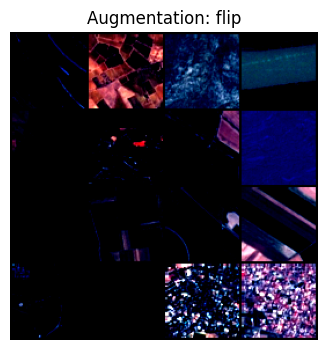

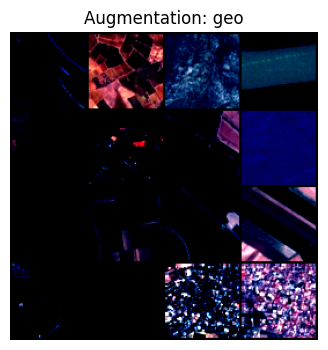

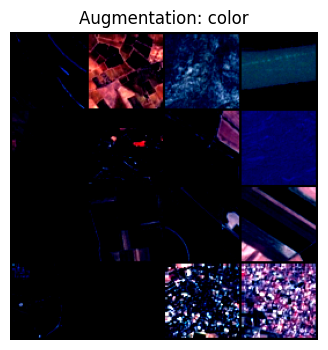

In [ ]:
# (B4) Data augmentation policies — [12 pts]

import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch


# TODO (B4): define a dictionary mapping policy name -> transforms.Compose
# Each policy should combine some of:
#   - flips,
#   - geometric transforms (rotation / crop / zoom),
#   - color or intensity changes.
# Policies should operate on PIL images only (do not include Resize/ToTensor here;
# those are handled by transform_eval from B1).
AUG_POLICIES = {
    # Example keys (you will fill in the actual transforms):
    # "flip": transforms.Compose([...]),
    # "geo": transforms.Compose([...]),
    # "color": transforms.Compose([...]),
}
## ADD YOUR CODE HERE ##

AUG_POLICIES.update({
    "none": transforms.Compose([]),

    "flip": transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.RandomVerticalFlip(p=0.5)
    ]),
    "geo": transforms.Compose([
        transforms.RandomRotation(degrees=90),
        transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=0, translate=(0.4, 0.1), scale=(0.9, 1.2))
    ]),
    "color": transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.8, saturation=0.5, hue=0.3),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
    ])
})


def make_aug_transform(name):
    """Build the training-time transform for a given augmentation policy.

    Parameters
    ----------
    name : str
        The name of an augmentation policy defined in AUG_POLICIES.

    Returns
    -------
    transform : callable
        A torchvision-style transform that expects a PIL image as input and
        returns a tensor with the same resizing/normalization behaviour as
        `transform_eval`, but with the chosen augmentation policy applied
        *before* the evaluation preprocessing.

    This transform is intended to be passed as the `train_transform` argument
    to `make_loaders(...)` in B1 for training models with data augmentation.
    """
    if name not in AUG_POLICIES:
        raise ValueError(f"Unknown augmentation policy: {name}")
    aug = AUG_POLICIES[name]
    # First apply augmentation (operating on PIL), then the base eval transform.
    return transforms.Compose([aug, transform_eval])

def show_augmented_batch(policy_names, batch_size=32, max_images=16):
    """Visualize how augmentation policies modify the *same* batch of images.

    Parameters
    ----------
    policy_names : str or list of str
        Name or list of names of policies defined in AUG_POLICIES.
    batch_size : int
        Batch size to request from the training DataLoader.
    max_images : int
        Maximum number of images to display per policy.

    The function resets the random seed before constructing each DataLoader
    so that the same subset of training examples is used for every policy.
    This makes the visual comparison across policies much easier.
    """
    if isinstance(policy_names, str):
        policy_names = [policy_names]

    import math
    n_show = min(batch_size, max_images)

    for name in policy_names:
        # Use the same underlying batch across policies by reseeding.
        torch.manual_seed(0)
        train_loader, _, _ = make_loaders(
            batch=batch_size,
            train_transform=make_aug_transform(name),
        )
        xb, yb = next(iter(train_loader))  # xb: [B, 3, 64, 64] after augmentation

        # Move to CPU and arrange into a grid.
        xb_cpu = xb.detach().cpu()
        grid = torchvision.utils.make_grid(
            xb_cpu[:n_show],
            nrow=int(math.sqrt(n_show)),
        )
        img = grid.numpy().transpose(1, 2, 0)
        img = np.clip(img, 0.0, 1.0)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Augmentation: {name}")
        plt.show()

# Example: after you have defined AUG_POLICIES and implemented make_aug_transform,
# you can uncomment and edit the following line to inspect your policies:
show_augmented_batch(["flip", "geo", "color"], batch_size=32, max_images=16)


# TODO (B4): using your best configuration from B3 and the policies in AUG_POLICIES,
#            call run_experiment(...) for at least three different policies,
#            collect metrics (e.g., val_acc, test_acc) in a table, and comment on the results. (Which augmentations helped most and why do you think this is the case for EuroSAT?)
## ADD YOUR CODE HERE ##

#best_configuration = df.iloc[0]

#set to avoid having to rerun previous cell (runtime: 30 minutes)
best_configuration = {"model_name": "CNN_B", "opt_name": "adam", "lr": 1e-3, "weight_decay": 0, "sched_name": "step"}

best_configuration

results = {
    "policy_name": [],
    "val_acc": [],
    "test_acc": [],
}

for policy_name in AUG_POLICIES.keys():
  train_transform = make_aug_transform(policy_name)

  hist, configuration = run_experiment(
      model_name=best_configuration["model_name"],
      opt_name=best_configuration["opt_name"],
      lr=best_configuration["lr"],
      weight_decay=best_configuration["weight_decay"],
      sched_name=best_configuration["sched_name"],
      epochs=B_HPARAMS["epochs"],
      batch=B_HPARAMS["batch"],
      momentum=B_HPARAMS["momentum"],
  )

  results["policy_name"].append(policy_name)
  results["val_acc"].append(hist["val_acc"])
  results["test_acc"].append(hist["test_acc"])

df2 = pd.DataFrame(results)
df2 = df2.sort_values(by="val_acc", ascending=False)
print(df2)
